# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tkinter as tk
import scipy.optimize as sco
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from fpdf import FPDF

# Importing datasets

In [292]:
CAC40=pd.read_csv('CAC40_index.csv',sep=';',index_col='Date')

In [293]:
CAC40_stock=pd.read_excel('CAC40 market.xlsx',index_col='Name')
CAC40_stock=CAC40_stock.iloc[1:,:]
CAC40_stock.index.name='Date'
CAC40_stock=CAC40_stock.dropna(axis='rows')

In [294]:
CAC40.index = pd.to_datetime(CAC40.index,infer_datetime_format=True)  
CAC40_stock.index=pd.to_datetime(CAC40_stock.index,infer_datetime_format=True)

C:\Users\niroo\AppData\Local\Temp\ipykernel_2780\3338622327.py:1: UserWarning:

Parsing '13/03/1990' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\niroo\AppData\Local\Temp\ipykernel_2780\3338622327.py:1: UserWarning:

Parsing '14/03/1990' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\niroo\AppData\Local\Temp\ipykernel_2780\3338622327.py:1: UserWarning:

Parsing '15/03/1990' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\niroo\AppData\Local\Temp\ipykernel_2780\3338622327.py:1: UserWarning:

Parsing '16/03/1990' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\niroo\AppData\Local\Temp\ipykernel_2780\3338622327.py:1: UserWarning:

Parsing '19/03/1990' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsi

# Portfolio class creation

In [567]:
class Portfolio:
    def __init__(self,data):
        self.data=data
    
    
    def portfolio(self,weights):
    #method that allows to know the daily performance of the fund
        portfolio=pd.DataFrame()
        portfolio['Portfolio']=np.sum(weights*self.data,axis=1)
        return portfolio
    
    def periodic_performance(self,weights,*period):
        #method that gives indicators of the fund in each perdiod, *perdiod concerns date input as string
        #method will return the indicators on all periods if not specified
        
        dataframe={}
        portfolio=self.portfolio(weights)
        
        if period:
            
            for date in period:
                performance=portfolio.loc[date].mean()[0]*252
                variance=portfolio.loc[date].std()[0]*np.sqrt(252)
                sharpe_ratio=performance/variance
                dataframe[date]=(performance,variance,sharpe_ratio)
            
        else:
            performance=portfolio.mean()[0]*252
            variance=portfolio.std()[0]*np.sqrt(252)
            sharpe_ratio=performance/variance
            dataframe['Moyenne depuis création']=(performance,variance,sharpe_ratio)
            
        return pd.DataFrame(dataframe,index=['Performance','Volatilité','Ratio Sharpe'])
    
        
    def cumulative_performance(self, weights, *start_date):
        #method that gives annalized performance and cumulative performance of the fund starting a given perdiod, *perdiod concerns date input as string
        #method will return the indicators on all periods if not specified
        
        dataframe = {}
        index = self.evolution(weights)
        
        if start_date:
            
            for period in start_date:
                
                start_performance = index.loc[index.index >= period].iloc[0][0]
                end_performance = index.loc[index.index >= period].iloc[-1][0]
                ratio = end_performance / start_performance
                cumulative_performance=(ratio-1)*100
                number_of_year = index.index[-1].year - int(period)
                annualized_performance = (ratio ** (1 / number_of_year)-1)*100
                if number_of_year==1: 
                    dataframe[str(number_of_year)+' AN'] = (cumulative_performance, annualized_performance)
                else:
                    dataframe[str(number_of_year)+' ANS'] = (cumulative_performance, annualized_performance)
        else:
            ratio=index.iloc[-1][0]/index.iloc[0][0]
            cumulative_performance=(ratio-1)*100
            number_of_year=index.index[-1].year-index.index[0].year
            annualized_performance=(ratio**(1/number_of_year)-1)*100
            dataframe[index.index[0].year]=(cumulative_performance,annualized_performance)
                
        return pd.DataFrame(dataframe, index=['Cumulée', 'Annualisée'])


    def daily_attribution(self,weights):
        #method that gives the contribution of each line to the overall performance
        
        return weights*self.data
        
    
    def performance_attribution(self,weights,number=None,*periods):
        #method that gives contribution of a line in average, if periods not specified the method gives contribution in average since the beginning
        # Else it gives contributions of each line on each period
        
        performance_attribution=self.daily_attribution(weights)
        
        for col in performance_attribution.columns:
                performance_attribution[col]=performance_attribution[col]/self.portfolio(weights)['Portfolio']*100
                
        if periods:
            dataframe={}
            for period in periods:
                average_attribution=performance_attribution.loc[period].mean(axis=0)
                dataframe[period]=average_attribution
            contribution=pd.DataFrame(dataframe,index=performance_attribution.columns)
        else:
            average_attribution=performance_attribution.mean()
            contribution=pd.DataFrame({'Contribution':average_attribution.sort_values(ascending=False)[:number]})
            
        return contribution
        
    
    def evolution(self,weights):
        #method that gives the evolution of the fund starting on a 100 basis at the beginning of the input data
        
        portfolio=self.portfolio(weights)
        index=pd.DataFrame()
        index['Portfolio']=(1+portfolio['Portfolio']).cumprod()*100
        return index
    
    def inventory(self,weights,number=None):
        #method that gives the nth biggest line on the portfolio
        
        inventory=pd.DataFrame(weights*100,index=self.data.columns,columns=['Poids']).sort_values(by=['Poids'],ascending=False)
        return inventory.iloc[:number,:]
    
    def performance(self,weights):
        performance=np.sum(self.data.mean()*weights)*252
        return performance
    
    def variance(self,weights):
        variance=np.sqrt(np.dot(weights.T,np.dot(self.data.cov(),weights)))*np.sqrt(252)
        return variance
    
    def sharpe_ratio(self,weights):
        return self.performance(weights)/self.variance(weights)
    
    
    def sum_equal_one(self, weight):
        return np.sum(weight) - 1   
    
    def optimize(self):
        n_assets = len(self.data.columns)
        weight = np.array([1 / n_assets] * n_assets)
        bounds = tuple((0, 1) for _ in range(n_assets))
        constraints = [{'type': 'eq', 'fun': self.sum_equal_one}]
        optimum_weights = sco.minimize(self.variance, weight, method='SLSQP', bounds=bounds, constraints=constraints)
        
        return optimum_weights.x

# Reporting class creation

In [654]:
class Reporting(Portfolio):
    
    def __init__(self,data,weights):
        self.weights=weights
        super().__init__(data)
        
    def performance_report(self,*years):
        periodic_performance=self.data.periodic_performance(self.weights,*years)
        cols=periodic_performance.columns
        
        new_col=['Periode']
        for col in cols:
            new_col.append(col)
            
        periodic_performance=periodic_performance.reset_index()
        periodic_performance.columns=new_col
        periodic_performance=periodic_performance.round(3)
        
        
        colors = [[0, '#051a73'], [0.5, '#FFFFFF'], [1, '#ebf2fc']]
        fig = ff.create_table(periodic_performance,colorscale=colors)
        for i in range(len(fig.layout.annotations)):
            fig.layout.annotations[i].font.size = 15
            
        return fig
    
    def cumulative_report(self,*years):
        
        cumulative_performance=self.data.cumulative_performance(self.weights,*years)
        cumulative_performance=cumulative_performance.round(4)
        
        for col in cumulative_performance.columns:
            cumulative_performance[col]=cumulative_performance[col].apply(lambda x: '{:.2f}%'.format(x))

        cumulative_performance=cumulative_performance.reset_index()
        cumulative_performance=cumulative_performance.rename(columns={'index': "PERFORMANCE"})

        colors = [[0, '#051a73'], [0.5, '#FFFFFF'], [1, '#FFFFFF']]
        fig = ff.create_table(cumulative_performance,colorscale=colors)
        for i in range(len(fig.layout.annotations)):
            fig.layout.annotations[i].font.size = 15
        fig.write_image('Perf.png')
        
        return fig
        
    def weights_report(self,number_of_securities=None):
        
        weights=self.data.inventory(self.weights,number_of_securities)
        weights
        
        fig=px.pie(weights,values='Poids',names=weights.index,color_discrete_sequence=px.colors.sequential.Blues,width=600,height=500)
        fig.update_layout(
            annotations=[
                go.layout.Annotation(
                    x=0.2,
                    y=1.05,
                    xref='paper',
                    yref='paper',
                    text='POIDS DU PORTEFEUILLE',
                    showarrow=False,
                    bgcolor='white',
                    opacity=0.8,
                    xanchor='left',
                    yanchor='bottom',
                    font=dict(size=17.5, color='#051a73')
                )
            ]
        )
        return fig
    
    def evolution_report(self):
        
        index=self.data.evolution(self.weights)
        fig = px.line(index)
        fig.update_layout(yaxis_title=None,width=1000,height=400,xaxis_title=None,
            annotations=[
                go.layout.Annotation(
                    x=0.90,
                    y=1,
                    text='Evolution de la valeur liquidative depuis sa création',
                    xref='paper',
                    yref='paper',
                    showarrow=False,
                    bgcolor='white',
                    opacity=0.8,
                    xanchor='right',
                    yanchor='bottom',
                    width=600,
                    height=30,
                    font=dict(size=20, color='#051a73'))],
                    paper_bgcolor='white',
                    plot_bgcolor='#f2f3f5')
        fig.update_layout(legend=dict(yanchor="top", y=-0.1, xanchor="left", x=0.45),legend_title=None)
        fig.update_traces(line_color='#051a73')
        
        return fig
    
    def contribution_report(self,number=None):
        contribution=self.data.performance_attribution(self.weights,number)
        contribution=contribution.loc[(contribution['Contribution']>1) | (contribution['Contribution']<-1)]
        fig=px.bar(contribution,x=contribution.index,y=contribution['Contribution'],color='Contribution',text='Contribution',color_continuous_scale='Blues',width=600,height=500)
        fig.update_layout(yaxis_title=None,xaxis_title=None,annotations=[
            go.layout.Annotation(
                    x=1.15,
                    y=1.025,
                    xref='paper',
                    yref='paper',
                    text='CONTRIBUTION A LA PERFORMANCE',
                    showarrow=False,
                    bgcolor='white',
                    opacity=0.8,
                    xanchor='right',
                    yanchor='bottom',
                    width=750,
                    height=30,
                    font=dict(size=17.5, color='#051a73')
                )
            ],plot_bgcolor='white')
        fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
        fig.update_coloraxes(showscale=False)
        
        return fig
    
    def show_reports(self,number_of_line=None,*periods):
        #this method gives in a tuple all the visuals 
        
        return self.performance_report(*periods),self.cumulative_report(*periods),self.weights_report(number_of_line),self.contribution_report(number_of_line),self.evolution_report()
        
    def download_reports(self,number_of_line=None,*periods):
        
        self.performance_report(*periods).write_image('Ratio2.png')
        self.cumulative_report(*periods).write_image('Performance.png')
        self.weights_report(number_of_line).write_image('Poids2.png')
        self.contribution_report(number_of_line).write_image('Contribution2.png')
        self.evolution_report().write_image('Evolution2.png')
        
        print('Reports images have been downloaded')
        
        
    

# Interface class creation 

In [655]:
class Interface:
    def __init__(self,data):
        self.data = data
        self.valeurs = {}
        self.labels = []
        self.entries = []
        self.root = tk.Tk()

    def valider(self):
        total = sum(float(entry.get()) for entry in self.entries)
        for i, label in enumerate(self.labels):
            self.valeurs[label.cget('text')] = float(self.entries[i].get())
        print('Voici votre portefeuille :')
        for key in self.valeurs:
            print(key,':', str(round(self.valeurs[key]*100,4)) + "%")
        self.root.destroy()

    def optimiser(self):
        opt = Portfolio(self.data).optimize()
        for i, label in enumerate(self.labels):
            self.valeurs[label.cget('text')] = opt[i]
            self.entries[i].delete(0, tk.END)
            self.entries[i].insert(0, str(opt[i]))
            
    def random(self):
        weights = np.random.rand(len(self.data.columns))
        weights=weights/weights.sum()
        for i, label in enumerate(self.labels):
            self.valeurs[label.cget('text')] = weights[i]
            self.entries[i].delete(0, tk.END)
            self.entries[i].insert(0, str(weights[i]))
            
    
    def reset(self):
        for entry in self.entries:
            entry.delete(0, tk.END)
            entry.insert(0, "0.0")


    def run(self):
        
        canvas = tk.Canvas(self.root, width=400, height=400)
        scrollbar = tk.Scrollbar(self.root, orient="vertical", command=canvas.yview)
        scrollbar.pack(side="right", fill="y")
        canvas.pack(side="left", fill="both", expand=True)
        canvas.configure(yscrollcommand=scrollbar.set)
        canvas.bind("<Configure>", lambda e: canvas.configure(scrollregion=canvas.bbox("all")))

      
        frame = tk.Frame(canvas)
        canvas.create_window((0, 0), window=frame, anchor="nw")

    
        for ticker in self.data.columns:
            sub_frame = tk.Frame(frame)
            sub_frame.pack(side=tk.TOP)

            label = tk.Label(sub_frame, text=ticker, width=40)
            label.pack(side=tk.LEFT)
            self.labels.append(label)

            entry = tk.Entry(sub_frame,width=30)
            entry.pack(side=tk.LEFT)
            entry.insert(0, "0.0")
            self.entries.append(entry)

        bouton_frame = tk.Frame(self.root)
        bouton_frame.pack(side=tk.TOP)

        bouton_valider = tk.Button(bouton_frame, text="Valider", command=self.valider)
        bouton_valider.pack(side=tk.RIGHT, padx=0, pady=0)

        bouton_reset = tk.Button(bouton_frame, text="Reset", command=self.reset)
        bouton_reset.pack(side=tk.RIGHT, padx=0,pady=0)

        bouton_optimiser = tk.Button(bouton_frame, text="Optimiser", command=self.optimiser)
        bouton_optimiser.pack(side=tk.RIGHT, padx=0, pady=0)

        bouton_random = tk.Button(bouton_frame, text="Aléatoire", command=self.random)
        bouton_random.pack(side=tk.RIGHT, padx=0, pady=0)

        self.root.update_idletasks()
        width = self.root.winfo_width()
        height = self.root.winfo_height()
        x = (self.root.winfo_screenwidth() // 2) - (width // 2)
        y = (self.root.winfo_screenheight() // 2) - (height // 2)
        self.root.geometry('{}x{}+{}+{}'.format(width, height, x, y))

        self.root.mainloop()
        return np.array(list(self.valeurs.values()))      

In [661]:
weights=Interface(CAC40_stock.pct_change()).run()

Voici votre portefeuille :
LAGARDERE GROUPE : 0.0%
ATOS : 0.0%
PUBLICIS GROUPE : 0.7295%
ACCOR : 0.0%
CARREFOUR : 0.0%
RENAULT : 0.0%
VEOLIA ENVIRON : 0.0%
BOUYGUES : 0.0%
SODEXO : 3.6933%
ARCELORMITTAL : 0.0%
CAPGEMINI : 0.0%
THALES : 14.9132%
PEUGEOT DEAD - CONT SEE.99278Y : 0.0%
CMPG.DES ETS.MICH. : 0.0%
LEGRAND : 0.0%
UNIBAIL RODAMCO WE STAPLED UNITS : 0.0%
SAINT GOBAIN : 0.0%
STMICROELECTRONICS : 0.0%
SOCIETE GENERALE : 0.0%
VIVENDI : 5.2246%
ENGIE : 0.0%
ORANGE : 12.6993%
CREDIT AGRICOLE : 0.0%
DASSAULT SYSTEMES : 9.1314%
PERNOD-RICARD : 6.3869%
DANONE : 15.0768%
SCHNEIDER ELECTRIC : 0.0%
L AIR LQE.SC.ANYME. POUR L ETUDE ET L EPXTN. : 0.1381%
VINCI : 0.0%
ESSILORLUXOTTICA : 12.2462%
AXA : 0.0%
SAFRAN : 0.0%
BNP PARIBAS : 0.0%
KERING : 0.0%
HERMES INTL. : 9.1295%
AIRBUS : 0.0%
SANOFI : 10.631%
TOTALENERGIES : 0.0%
L'OREAL : 0.0%
LVMH : 0.0%


In [662]:
test=Reporting(Portfolio(CAC40_stock.pct_change()),weights)

In [663]:
#If download_reports not working use the show_reports and downloads image one by one
#since data stops a 2022 maxium periods in *periods is 2021 (can't return result for show_reports('2022'))
test.download_reports(10,'2021','2020','2019')

Reports images have been downloaded


In [664]:
def create_reporting():
    width=210
    height=297
    pdf=FPDF()
    pdf.add_page()
    pdf.set_font('Arial','B',16)
    pdf.image('LOGO BPV.png',0,0,250,210)
    pdf.image("Evolution2.png",5,35,205,205/2.5)
    pdf.image('Performance.png',5,117,155,28)
    pdf.image('Ratio2.png',5,155,155,35)
    pdf.image('Poids2.png',5,195,100,100/1.1)
    pdf.image('Contribution2.png',101,195,110,110/1.1)
    pdf.output('Reporting.pdf')

In [665]:
create_reporting()

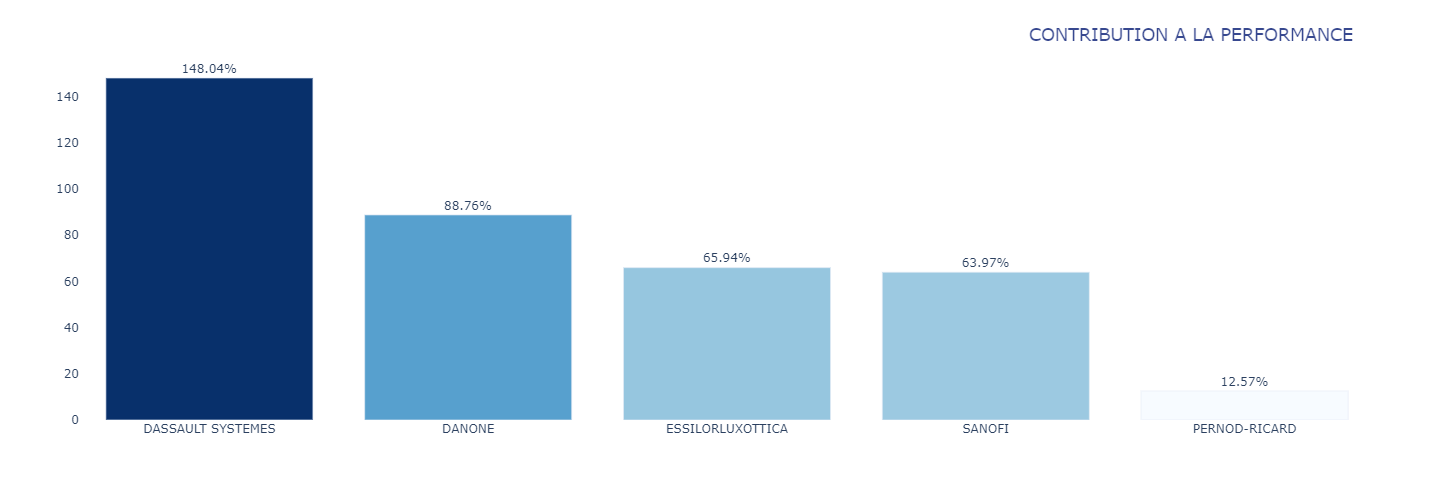

In [670]:
test.show_reports(5,'2021','2020','2019')[3]